In [2]:
pip install opencv-python


In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from google.colab import drive

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [5]:
# Pra-pemrosesan dengan peningkatan gambar dan pengurangan blur
def preprocess_image(image):
    # Resize dan Rescaling
    image = resize_scale(image)

    # Data Augmentation
    image = data_augmentation(image)

    # Ubah ke array NumPy
    image_numpy = tf.image.rgb_to_grayscale(image).numpy()[0]  # Ambil elemen pertama dari batch tensor
    image_numpy = (image_numpy * 255).astype(np.uint8)  # Konversi ke tipe data CV_8UC1

    # Peningkatan gambar dengan pengurangan blur (GaussianBlur)
    image_numpy = cv2.GaussianBlur(image_numpy, (3, 3), 0)  # Mengurangi ukuran kernel

    # Peningkatan gambar dengan filter bilateral
    image_numpy = cv2.bilateralFilter(image_numpy, 9, 75, 75)

    # Peningkatan gambar dengan pencahayaan (Brightness)
    image = tf.image.adjust_brightness(image_numpy, delta=0.1)  # Mengurangi nilai delta

    return image


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
# Path dataset di Google Drive
base_path = '/content/drive/My Drive/dataset/PLD_3_Classes_256'

In [8]:
# Load dataset
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    f'{base_path}/Training',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

testing_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    f'{base_path}/Testing',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    f'{base_path}/Validation',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3251 files belonging to 3 classes.
Found 405 files belonging to 3 classes.
Found 416 files belonging to 3 classes.


In [9]:
class_names = training_dataset.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

In [10]:
len(training_dataset)

102

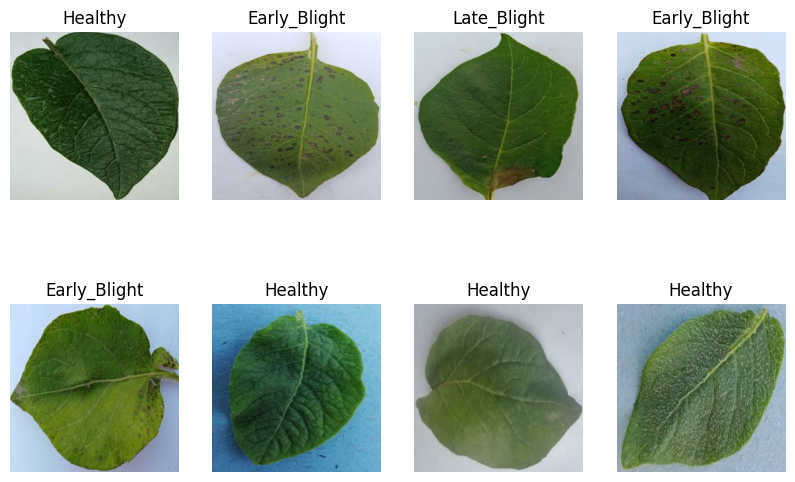

In [11]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in training_dataset.take(1):
    for i in range(0,8):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [12]:
train_data = training_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_data = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = testing_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_scale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
input_shape = (32, IMAGE_SIZE, IMAGE_SIZE, 3)

model = tf.keras.Sequential([
    resize_scale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(len(class_names),activation='softmax'),
])
model.build(input_shape=input_shape)

In [16]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Labels: Late_Blight


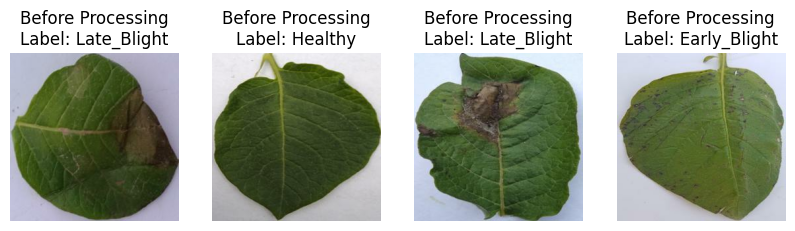

In [25]:
# Menampilkan label
print("Labels:", class_names[np.array(label_batch)[0]])

# Menampilkan gambar sebelum dan sesudah pemrosesan
plt.figure(figsize=(10, 10))
for i in range(4):
    # Menampilkan gambar sebelum pemrosesan
    plt.subplot(2, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(f"Before Processing\nLabel: {class_names[np.array(label_batch)[i]]}") # Mengubah indeks menjadi [i]
    plt.axis("off")



In [20]:
model.fit(
    training_dataset,
    epochs=5,
    batch_size=32,
    verbose=1,
    validation_data=validation_dataset
)

Epoch 1/5
102/102 [==============================] - 607s 6s/step - loss: 0.9751 - accuracy: 0.5260 - val_loss: 0.8087 - val_accuracy: 0.6178
Epoch 2/5
102/102 [==============================] - 513s 5s/step - loss: 0.6890 - accuracy: 0.7250 - val_loss: 0.5386 - val_accuracy: 0.7909
Epoch 3/5
102/102 [==============================] - 514s 5s/step - loss: 0.4821 - accuracy: 0.8201 - val_loss: 0.3618 - val_accuracy: 0.8630
Epoch 4/5
102/102 [==============================] - 457s 4s/step - loss: 0.3953 - accuracy: 0.8456 - val_loss: 0.3794 - val_accuracy: 0.8462
Epoch 5/5
102/102 [==============================] - 455s 4s/step - loss: 0.2735 - accuracy: 0.8988 - val_loss: 0.2031 - val_accuracy: 0.9375


In [23]:
model.evaluate(test_data)

13/13 [==============================] - 60s 1s/step - loss: 0.2775 - accuracy: 0.9062


[0.2775249481201172, 0.9061728119850159]

The Image Title :  Late_Blight
1/1 [==============================] - 1s 1s/step
Model Predicted label :  Late_Blight


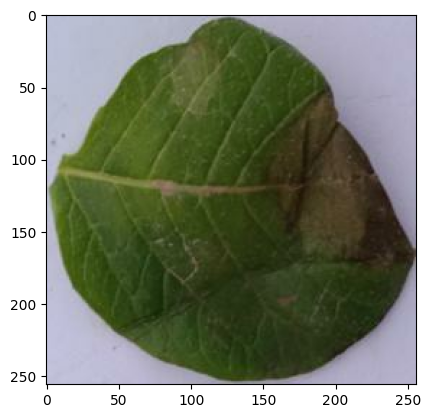

In [24]:
for image_batch,label_batch in test_data.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    print("The Image Title : ",class_names[label_batch[0].numpy()])
    prediction = model.predict(image_batch)
    print("Model Predicted label : ",class_names[np.argmax(prediction[0])])

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Evaluasi model pada dataset pengujian
loss, accuracy = model.evaluate(test_data)

# Menampilkan nilai loss dan accuracy
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

# Inisialisasi list untuk menyimpan hasil prediksi dan label sebenarnya
predicted_labels = []
true_labels = []

# Loop melalui dataset pengujian untuk mendapatkan prediksi
for image_batch, label_batch in test_data:
    predictions = model.predict(image_batch)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(label_batch.numpy())

# Menghitung precision, recall, dan f1 score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Menampilkan hasil metrik
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')


13/13 [==============================] - 15s 1s/step - loss: 0.2775 - accuracy: 0.9062
Test Loss: 0.2775, Test Accuracy: 0.9062
1/1 [==============================] - 1s 1s/step
Precision: 0.9061, Recall: 0.9062, F1 Score: 0.9048
